## Embedding Reveiws
- use TCU, otherwise, running Llama and Falcon will take up all RAM if you use CPU.

In [ ]:
!pip install transformers

In [2]:
import transformers
import torch

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
!pip install --upgrade huggingface_hub

In [5]:
from huggingface_hub import login

In [6]:
login()

In [11]:
!pip install gensim nltk

In [ ]:
!pip install pandas==2.2.2
!pip install numpy<3.0.0,>=2.0.0

In [ ]:
!pip install --force-reinstall gensim

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import torch
from gensim.models import Word2Vec
import gensim

# Tutorial from NLTK: https://www.nltk.org/data.html
# train the word2vec model that learns the word meaning in the bubble tea reviews

In [2]:
# nltk.download() # this one runs endless
nltk.download('punkt')
nltk.download('punkt_tab')
# punkt explains: https://www.askpython.com/python-modules/nltk-punkt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Preprocess Data

In [3]:
df = pd.read_csv("All Reviews.csv")

# df['Rating'] = df['Rating'].str.extract(r"(\d+)")
# for i in range(len(df)):
#     if df['Reviews'][i] == 'No review text available':
#         df = df.drop(i)

reviews = df["Reviews"]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   607 non-null    int64 
 1   Reviews  607 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.6+ KB


## Word2Vec
- tutorial: https://radimrehurek.com/gensim/models/word2vec.html

In [4]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha()] # if word is alphabet letters

tokenized_reviews = []
# tokenize each review
for review in reviews:
    tokenized_reviews.append(preprocess(review))

# tokenized_reviews
# [['babo', 'tea'],['I','love', 'this']... ]

In [14]:
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=300, window=5, min_count=2, workers=4)

In [15]:
# This func transfers review tokens into vectors
def get_w2v_review_vector(tokens, model):

    # only keep the word in W2V model's vocabulary
    recognized_word_in_review= []
    word_vector = []

    for w in tokens:
        if w in model.wv.key_to_index: # {'the': 0, 'and': 1, 'i': 2,...}
            recognized_word_in_review.append(w)

    # if a review contains no model vocabuary, set its vector 0
    if len(recognized_word_in_review) == 0:
        return np.zeros(model.vector_size)

    # if has value, get the word vector and calculate the avg
    for w in recognized_word_in_review:
        word_vector.append(model.wv[w])

    review_vector = np.mean(word_vector, axis = 0)
    return review_vector

In [26]:
w2v_review_vectors = []
for tokens in tokenized_reviews:
    vector = get_w2v_review_vector(tokens, w2v_model)
    w2v_review_vectors.append(vector)

In [27]:
w2v_review_vectors = np.array(w2v_review_vectors) #convert it into a np array
print(w2v_review_vectors.shape)
# 607 reviews, each review is represented as 100-D vector

(607, 300)


Normalize rating & Reshape dimentions: convert 1-5 scale into 0~1

In [24]:
ratings = df["Rating"]
normalized_ratings = np.array(ratings, dtype=float) / 5

# reshape normalized ratings into (607, 1)
reshaped_ratings = normalized_ratings.reshape(-1,1)
reshaped_ratings.shape

(607, 1)

Combine normalized ratings with review vectors

In [28]:
w2v_rating_combined_vectors = np.hstack((w2v_review_vectors, reshaped_ratings))
w2v_rating_combined_vectors.shape

(607, 301)

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(reviews)
tfidf_vectors = tfidf_matrix.toarray()

tfidf_rating_combined_vectors = np.hstack((tfidf_vectors, reshaped_ratings))
tfidf_rating_combined_vectors.shape

## Llama 2-7b-chat-hf
- meta download: https://www.llama.com/llama-downloads/
- Huggingface: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
- [Github tutorial](https://github.com/meta-llama/llama-models?fbclid=IwZXh0bgNhZW0CMTAAAR5flYgamnz7bViaAtMQsPvPWGc7jCd69MsAmom7zGFl6Mb9ckvqDYBeACJirg_aem_vjalf1yaPdUasJh9lNKd_g)

In [35]:
from transformers import AutoTokenizer, AutoModelForCausalLM

llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
llama_model.config.output_hidden_states = True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [37]:
def get_llama_vector(review, tokenizer, model):

    input = tokenizer(review, return_tensors='pt', truncation=True)

    with torch.no_grad():
        outputs = model(**input)

    hidden_states = outputs.hidden_states[-1]  #get hidden states from the last layer

    vector = hidden_states.mean(dim=1).squeeze().numpy()  #average all tokens

    return vector

In [38]:
llama_vectors = []

for review in reviews:
    vector = get_llama_vector(review, llama_tokenizer, llama_model)
    llama_vectors.append(vector)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [39]:
llama_rating_combined_vectors = np.hstack((llama_vectors, reshaped_ratings))
llama_rating_combined_vectors.shape

(607, 4097)

## Falcon

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

falcon_tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b", trust_remote_code=True)
falcon_model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-7b", trust_remote_code=True)
falcon_model.config.output_hidden_states = True

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generate vectors by using Transformers

In [ ]:
def get_review_vector(review, tokenizer, model):

    input = tokenizer(review, return_tensors='pt', truncation=True)

    with torch.no_grad():
        outputs = model(**input)

    hidden_states = outputs.hidden_states[-1]  #get hidden states from the last layer

    vector = hidden_states.mean(dim=1).squeeze().numpy()  #average all tokens

    return vector

In [ ]:
all_llama_vectors = []

for review in reviews:
    vector = get_review_vector(review, llama_tokenizer, llama_model)
    all_llama_vectors.append(vector)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
all_falcon_vectors = []
# only use Indianapolis data - 81 entries

for review in reviews:
    vector = get_review_vector(review, falcon_tokenizer, falcon_model)
    all_falcon_vectors.append(vector)


In [ ]:
llama_rating_combined_vectors = np.hstack((all_llama_vectors, reshaped_ratings))
llama_rating_combined_vectors.shape

(60, 4097)

,Rating,Reviews,Cluster
0,5,The aesthetic is very cozy and inviting!! The ...,4
1,5,Tiger sugar is the epitome of a welcoming envi...,4
2,5,"If you are in or near Greenwood, IN looking fo...",4
3,3,A friend of mine had a negative experience her...,4
4,5,I never give reviews but i wanted to let yall ...,4


## PCA

In [32]:
df["Cluster"] = labels
df.head()

,Rating,Reviews,Cluster
0,5,Absolutely love this place! Tiger Sugar never ...,0
1,5,Best boba in Colorado hands down.\n\nWe got a ...,0
2,5,Tiger Sugar’s boba teas are very different fro...,0
3,5,Absolutely amazing bubble tea! TIGER SUGAR nev...,0
4,5,Great taste! So glad that there’s an affordabl...,0


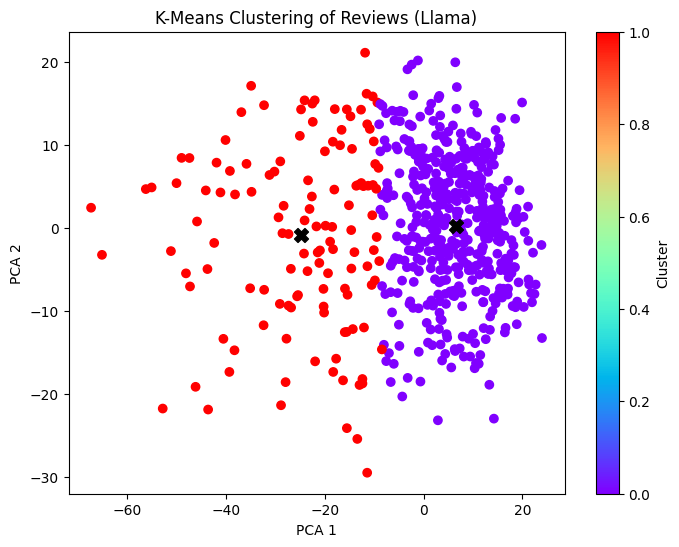

Silhouette Score for k=2: 0.220


In [58]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state=42)
kmeans.fit(llama_rating_combined_vectors)
labels = kmeans.labels_

pca = PCA(n_components=2)
reduced = pca.fit_transform(llama_rating_combined_vectors)

centers_reduced = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='rainbow')
plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1],
            marker='X', s=100, c='black')


plt.title("K-Means Clustering of Reviews (Llama)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')

plt.show()

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(llama_rating_combined_vectors, labels)
print(f"Silhouette Score for k=2: {sil_score:.3f}")

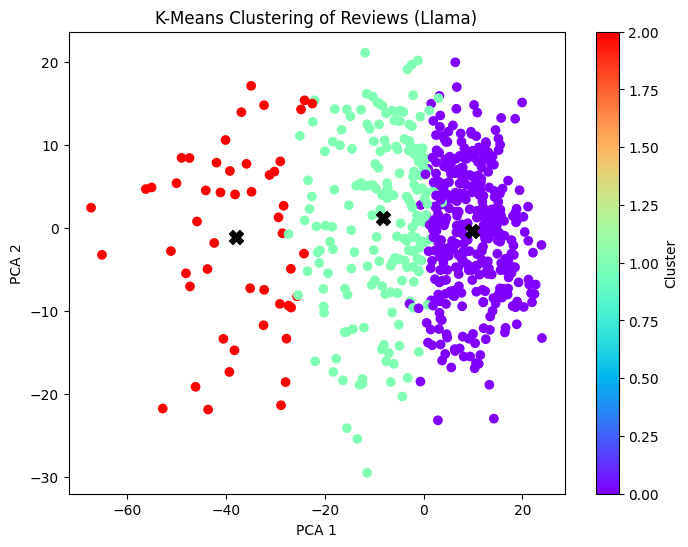

Silhouette Score for k=3: 0.095


In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state=42)
kmeans.fit(llama_rating_combined_vectors)
labels = kmeans.labels_

pca = PCA(n_components=2)
reduced = pca.fit_transform(llama_rating_combined_vectors)

centers_reduced = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='rainbow')
plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1],
            marker='X', s=100, c='black')


plt.title("K-Means Clustering of Reviews (Llama)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')

plt.show()

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(llama_rating_combined_vectors, labels)
print(f"Silhouette Score for k=3: {sil_score:.3f}")

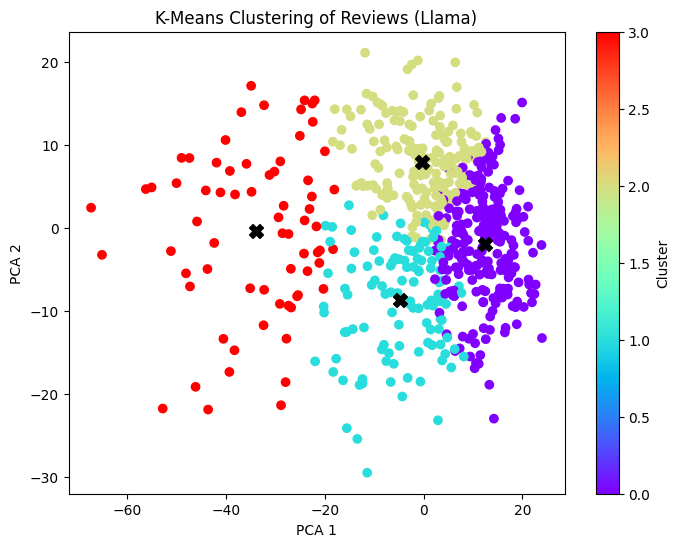

Silhouette Score for k=4: 0.052


In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4, random_state=42)
kmeans.fit(llama_rating_combined_vectors)
labels = kmeans.labels_

pca = PCA(n_components=2)
reduced = pca.fit_transform(llama_rating_combined_vectors)

centers_reduced = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='rainbow')
plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1],
            marker='X', s=100, c='black')


plt.title("K-Means Clustering of Reviews (Llama)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')

plt.show()

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(llama_rating_combined_vectors, labels)
print(f"Silhouette Score for k=4: {sil_score:.3f}")

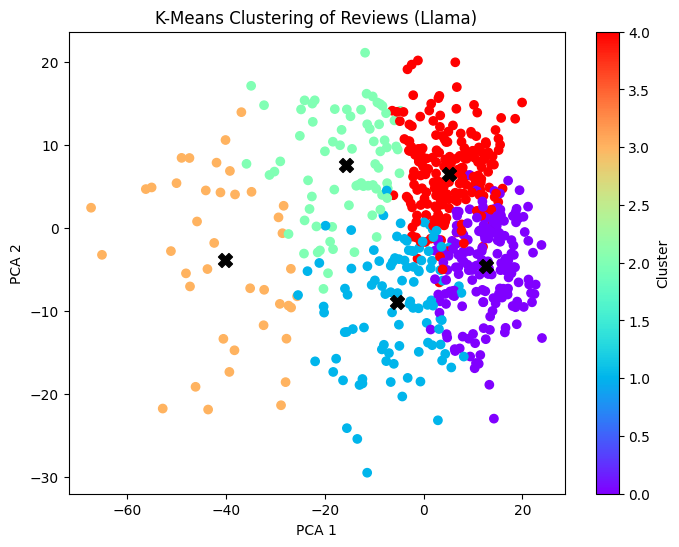

Silhouette Score for k=5: 0.040


In [62]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=42)
kmeans.fit(llama_rating_combined_vectors)
labels = kmeans.labels_

pca = PCA(n_components=2)
reduced = pca.fit_transform(llama_rating_combined_vectors)

centers_reduced = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='rainbow')
plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1],
            marker='X', s=100, c='black')


plt.title("K-Means Clustering of Reviews (Llama)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')

plt.show()

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(llama_rating_combined_vectors, labels)
print(f"Silhouette Score for k=5: {sil_score:.3f}")

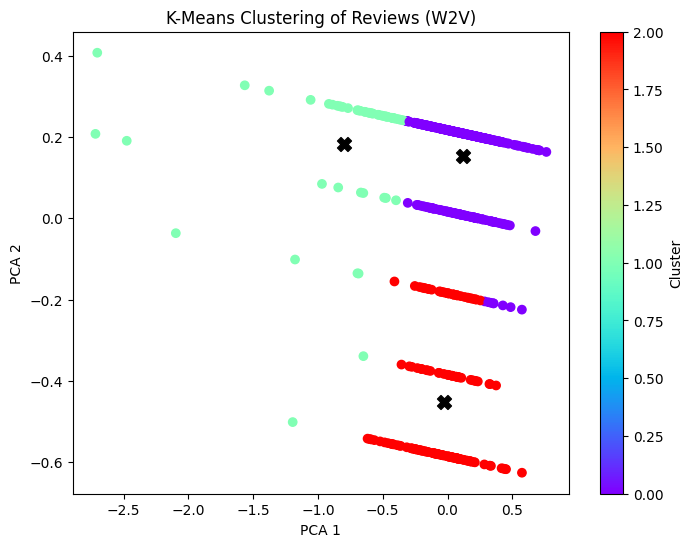

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state=42)
kmeans.fit(w2v_rating_combined_vectors)
labels = kmeans.labels_

pca = PCA(n_components=2)
reduced = pca.fit_transform(w2v_rating_combined_vectors)

centers_reduced = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='rainbow')
plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1],
            marker='X', s=100, c='black')


plt.title("K-Means Clustering of Reviews (W2V)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.22027603015384328
For n_clusters = 3 The average silhouette_score is : 0.06002599773590344
For n_clusters = 4 The average silhouette_score is : 0.05008133487274087
For n_clusters = 5 The average silhouette_score is : 0.042161864708369176
For n_clusters = 6 The average silhouette_score is : 0.03400404228546616


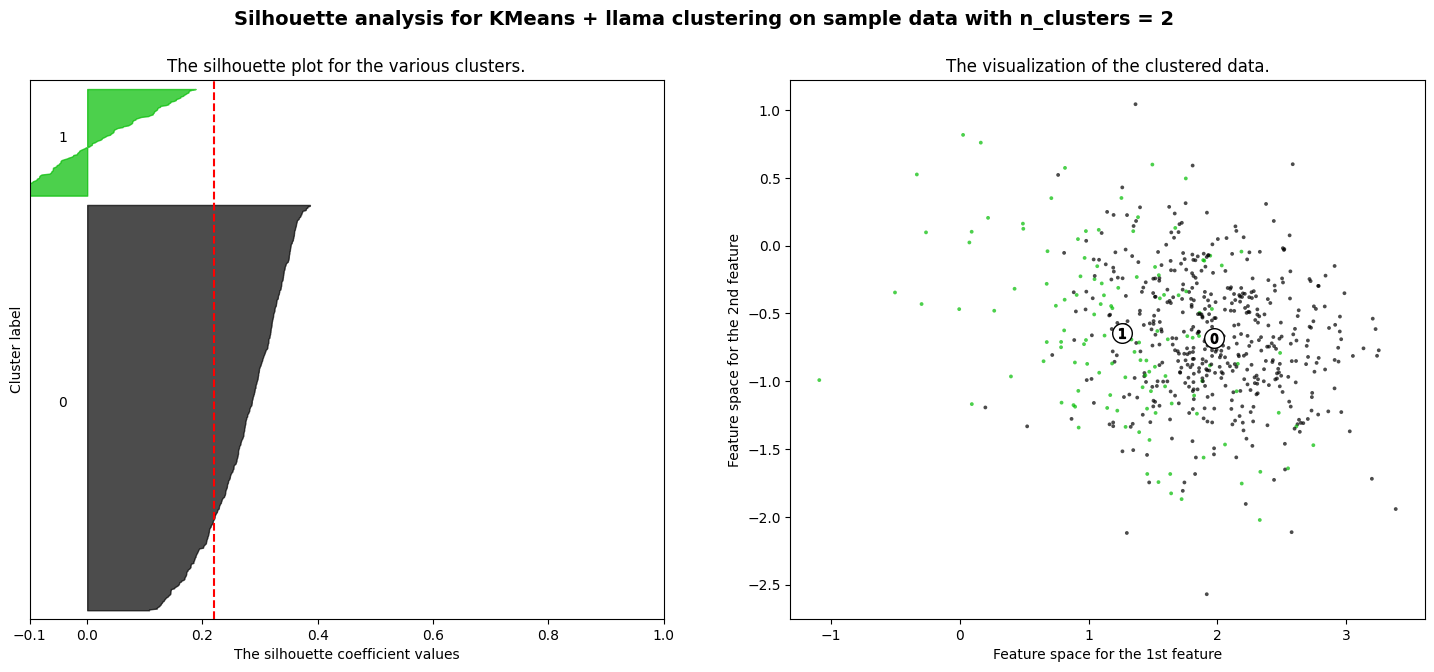

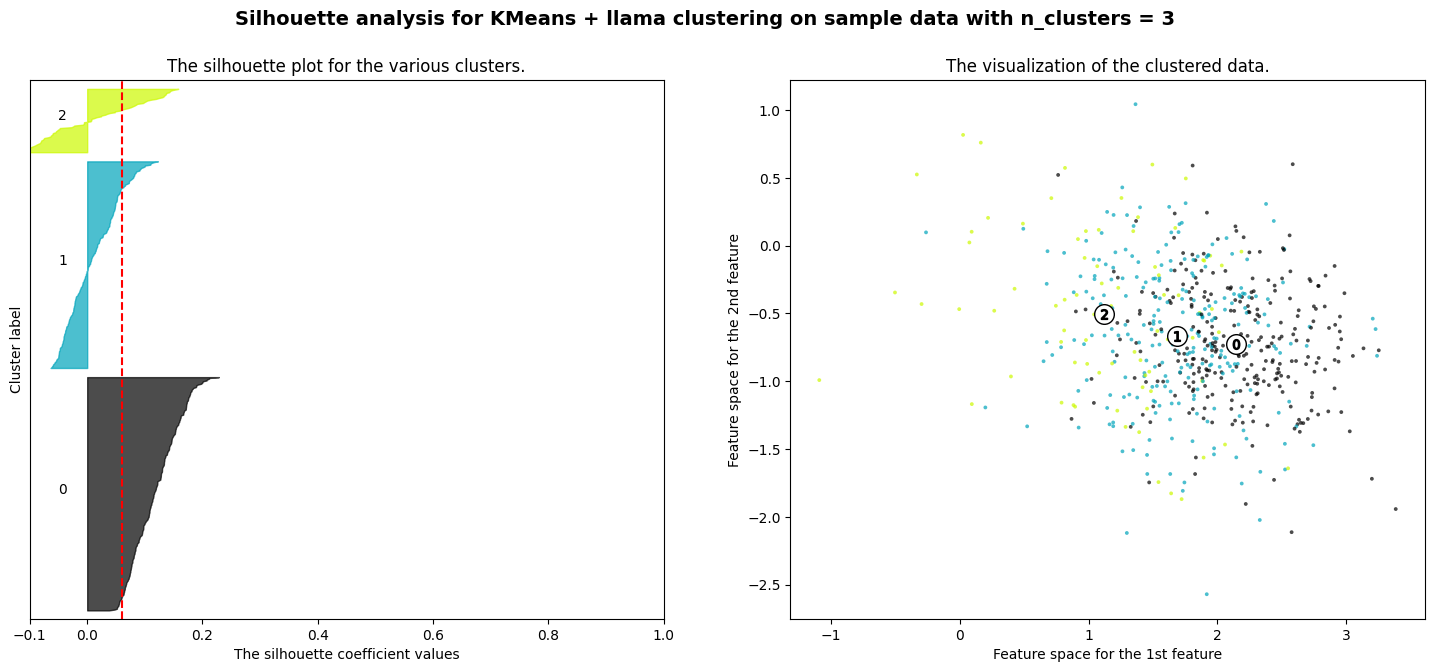

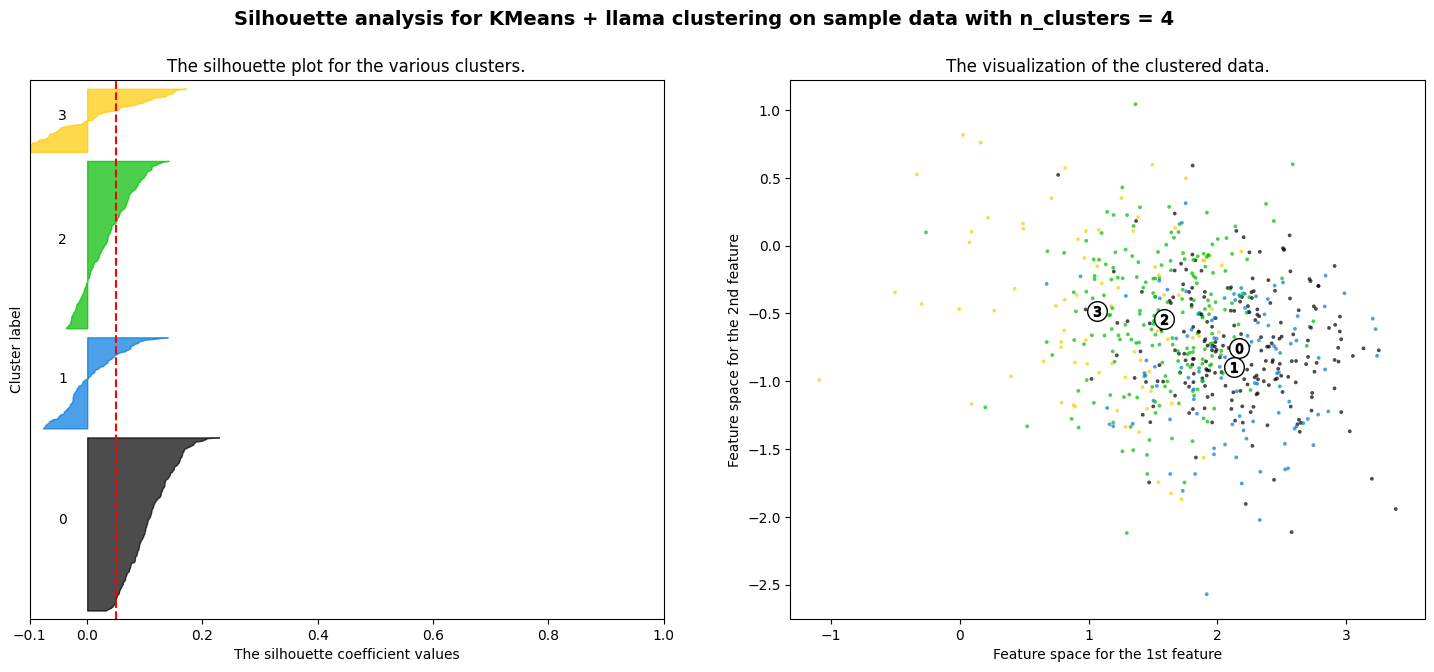

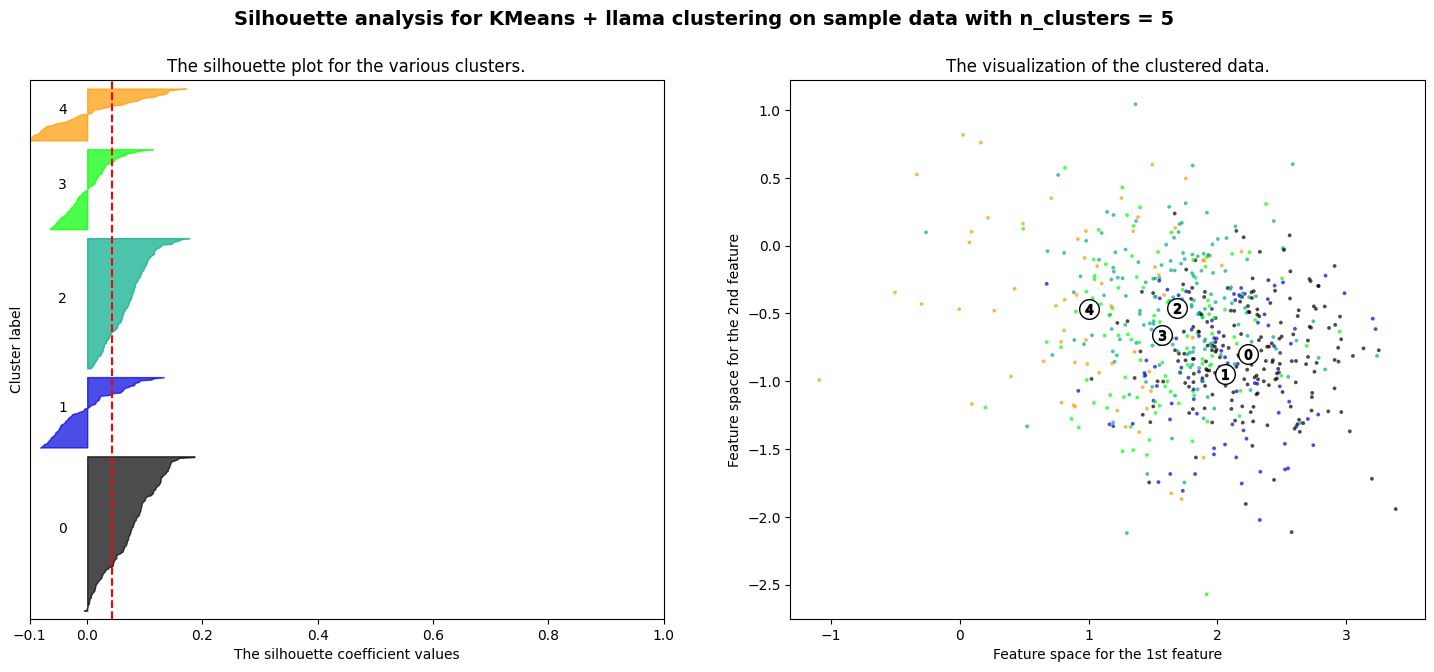

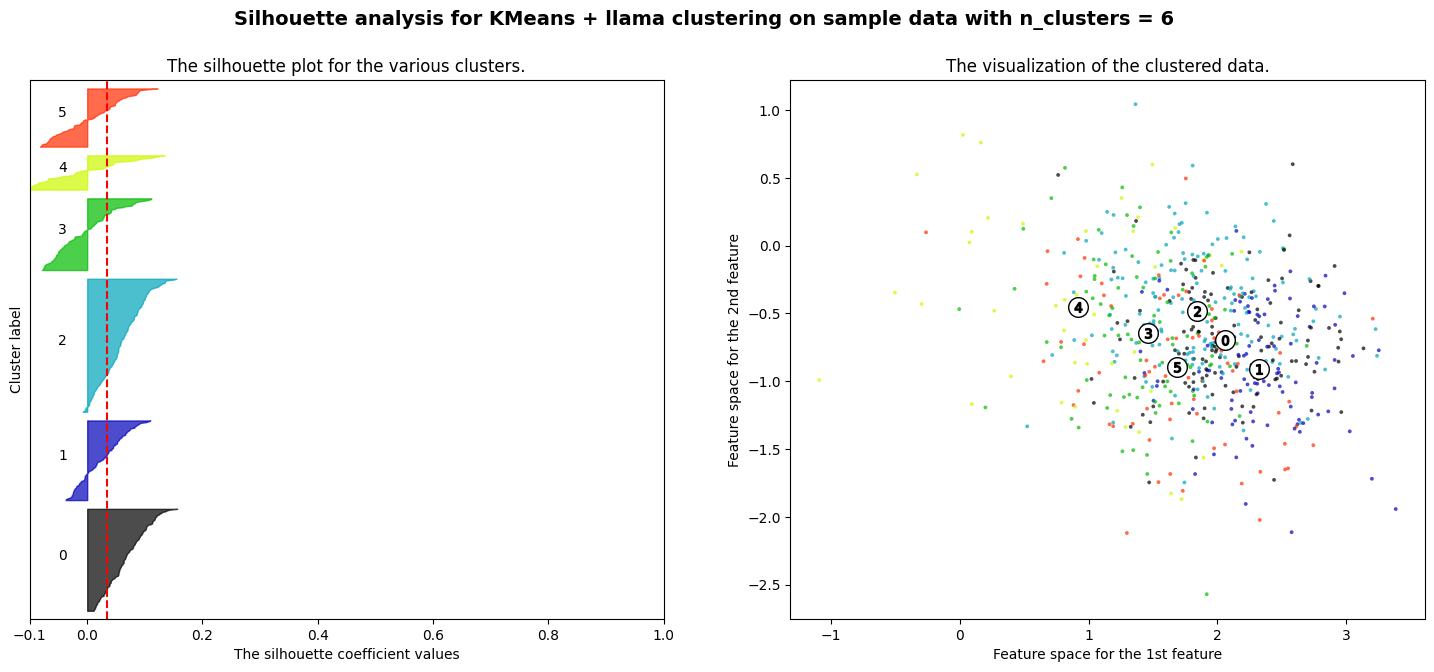

In [42]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X =  np.array(llama_rating_combined_vectors)  #<==== change vectors

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans + llama clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()